In [2]:
# import requiered libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

#import custom functions
from ms_custom_functions import *

# Hide warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
!git branch -a

* QC
  feature/extraxt-patient-data
  main
  update/extract-patient-data
  remotes/origin/HEAD -> origin/main
  remotes/origin/br1_sg
  remotes/origin/feature/extraxt-patient-data
  remotes/origin/main
  remotes/origin/ralf/add-data-overview
  remotes/origin/update/extract-patient-data


In [6]:
# Read raw train data
train = pd.read_csv( '../data/raw/train.csv' )
train.head()

,id,p_num,time,bg-5:55,bg-5:50,bg-5:45,bg-5:40,bg-5:35,bg-5:30,bg-5:25,...,activity-0:40,activity-0:35,activity-0:30,activity-0:25,activity-0:20,activity-0:15,activity-0:10,activity-0:05,activity-0:00,bg+1:00
0,p01_0,p01,06:10:00,NaN,NaN,9.6,NaN,NaN,9.7,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.4
1,p01_1,p01,06:25:00,NaN,NaN,9.7,NaN,NaN,9.2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.8
2,p01_2,p01,06:40:00,NaN,NaN,9.2,NaN,NaN,8.7,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.5
3,p01_3,p01,06:55:00,NaN,NaN,8.7,NaN,NaN,8.4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.8
4,p01_4,p01,07:10:00,NaN,NaN,8.4,NaN,NaN,8.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.7


In order to comapre the quakity/integritry of the parsed data, we can compare the set of unique nonNA values from the parsed and raw data, for each patient and metric/feature.

Since these set of values should be the same, comparing their mean, std, min & max should give a difference of cero

In [11]:
# List of ids to check
ids = ['p01','p02','p03','p04','p05','p06','p10','p11','p12']
metrics = ['bg','insulin','carbs','hr','steps','cals']

# Instantiate an empty list to store results
res_l = list()

# Run a For loop
for id in ids:
    for metric in metrics:
        # print(id,metric) 
        checks_df , _ , _  , _ , _ = compare_data( id , metric , train )
        res_l.append( checks_df )

In [13]:
# Join the individual DataFrames
res_df = pd.concat( res_l ).drop('diff_check',axis=1)
pivot_df = pd.pivot( res_df , index = ['p_id','feature'] , columns = 'metric' , values ='diff' )
pivot_df.reset_index( inplace = True )
pivot_df = pivot_df[['p_id','feature','mean','std','min','max']]
pivot_df

metric,p_id,feature,mean,std,min,max
0,p01,bg,0.000000,0.000000,0.0,0.0
1,p01,cals,0.000000,0.000000,0.0,0.0
2,p01,carbs,0.000000,0.000000,0.0,0.0
3,p01,hr,0.000000,0.000000,0.0,0.0
4,p01,insulin,0.000000,0.000000,0.0,0.0
5,p01,steps,0.000000,0.000000,0.0,0.0
6,p02,bg,0.000000,0.000000,0.0,0.0
7,p02,cals,0.000000,0.000000,0.0,0.0
8,p02,carbs,0.000000,0.000000,0.0,0.0
9,p02,hr,0.000000,0.000000,0.0,0.0


We notice that only the values of 'cals' for patient p11 show a difference between the raw and parsed data. In the next cell we compare the set of values for cals from p11 in the raw (val1_df) and parsed ( val2_df )

In [27]:
checks_df , val1_df , val2_df , df_raw , df_parsed = compare_data( 'p11' , 'cals' , train )
set(val1_df.vals) - set(val2_df.vals)

{nan, 15.36}

Only one problematic value was found. We modified the `extract_patient_data()`, including checks to see where the value of 15.36. In the output of the next cell, dfs1 corresponds to the raw data for p11. And dfs2 is the parsed data for the same patient

In [30]:
patient_data , dfs1 , dfs2 = extract_patient_data_ms( train , 'p11', datetime(2020, 1, 1) )
print( (dfs1==15.36).any().any() )
print( (dfs2==15.36).any().any() )

Check 1: True
Check 1b: True
Check 2 debug: False
Check 2: False
Check 3: False
Check 4: False
True
False


In [32]:
ix = np.where( (dfs1==15.36).any() )[0]
dfs1.columns[ ix ]

Index(['cals-5:55', 'cals-5:50', 'cals-5:45', 'cals-5:40', 'cals-5:35',
       'cals-5:30', 'cals-5:25', 'cals-5:20', 'cals-5:15', 'cals-5:10',
       'cals-5:05', 'cals-5:00', 'cals-4:55', 'cals-4:50', 'cals-4:45',
       'cals-4:40', 'cals-4:35', 'cals-4:30', 'cals-4:25', 'cals-4:20',
       'cals-4:15', 'cals-4:10', 'cals-4:05', 'cals-4:00', 'cals-3:55',
       'cals-3:50', 'cals-3:45', 'cals-3:40', 'cals-3:35', 'cals-3:30',
       'cals-3:25', 'cals-3:20', 'cals-3:15', 'cals-3:10', 'cals-3:05',
       'cals-3:00', 'cals-2:55', 'cals-2:50', 'cals-2:45', 'cals-2:40',
       'cals-2:35', 'cals-2:30', 'cals-2:25', 'cals-2:20', 'cals-2:15',
       'cals-2:10', 'cals-2:05', 'cals-2:00', 'cals-1:55', 'cals-1:50',
       'cals-1:45', 'cals-1:40', 'cals-1:35'],
      dtype='object')

The previous cell shows that  the value of 15.36 is absent from the cals columns afterthe -1:35 offset. In fact, inspecting the file via Excel shows that the value 15.36 changes  to 21.88

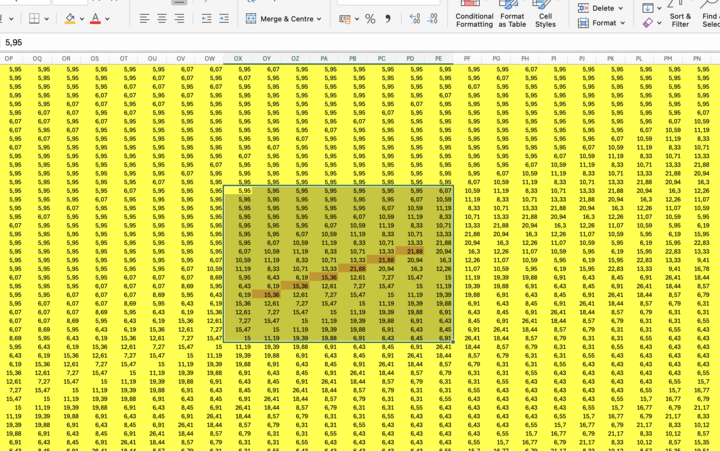

## Conclusion:
Besides a single problematic value, the parsed data is in good shape to be used for EDA of ML modelling. The single conflicting value is unlikley to affect future analytical conclusions